# Timeseries Smoothing

This notebook is a supplementary notebook to NDVI_Timeseries.ipynb, where we aim to improve the plot's smoothness by using a kernel as an UDF. The kernel will help to reduce noise and fluctuations in the data, resulting in a smoother and more accurate representation of the NDVI timeseries.

In [2]:
from openeo.rest.conversions import timeseries_json_to_pandas
import pandas as pd
import matplotlib.pyplot as pl
import shapely.geometry
import json
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import openeo

In [3]:
# connect to the backend and authenticate

connection = openeo.connect(url = "openeo-staging.creo.vito.be").authenticate_oidc()

Authenticated using refresh token.


In [4]:
# define a function to plot timeseries

DEFAULT_FIGSIZE = (5, 4)

def plot_timeseries(filename):
    """Helper to plot the timeseries directly from JSON file"""
    with open(filename) as f:
        ts = timeseries_json_to_pandas(json.load(f)).dropna()
    ts.index = pd.to_datetime(ts.index)
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ts.plot(marker='o', ax=ax)
    ax.set_title("Average NDVI"); ax.set_ylabel("NDVI");ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

First, load the fields as shapely geometries

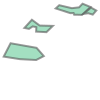

In [5]:

fields_geojson = '{"type": "GeometryCollection", "geometries": [{"type": "Polygon", "coordinates": [[[5.055945487931457, 51.222709834076504], [5.064972484168688, 51.221122565090525], [5.064972484168688, 51.221122565090525], [5.067474954083448, 51.218249806779134], [5.064827929485983, 51.21689628072789], [5.05917785594747, 51.217191909908095], [5.053553857094518, 51.21807492332223], [5.055945487931457, 51.222709834076504]]]}, {"type": "Polygon", "coordinates": [[[5.063345886679116, 51.23087606640057], [5.06604742694687, 51.22886710731809], [5.070627820472246, 51.22874440121892], [5.068403609708207, 51.22657208381529], [5.064823257492447, 51.22676051738515], [5.064892324615199, 51.2283032878514], [5.063641745941974, 51.2285757299238], [5.062340811262595, 51.227722351687945], [5.06076005158084, 51.228042312276536], [5.063345886679116, 51.23087606640057]]]}, {"type": "Polygon", "coordinates": [[[5.07163184674986, 51.23481147556147], [5.076706025697324, 51.23317590781036], [5.077828303041866, 51.233226237184724], [5.078024733866917, 51.23263978271262], [5.080771081607657, 51.23259097170763], [5.083734842574312, 51.23530464074437], [5.080957826735458, 51.23646091560258], [5.079752631651647, 51.23519531038643], [5.077238400183506, 51.23490534677628], [5.072856439300575, 51.23593546777778], [5.07163184674986, 51.23481147556147]]]}, {"type": "Polygon", "coordinates": [[[5.083897244679042, 51.23510639883143], [5.081302408741335, 51.232922477780846], [5.082963802194108, 51.233146058575876], [5.084497702305552, 51.232672717580655], [5.085732850338428, 51.2340852086282], [5.083897244679042, 51.23510639883143]]]}]}'
fields = shapely.geometry.shape(json.loads(fields_geojson))
fields

Like before, we load like a data cube and calculate the NDVI, but we now use a larger time window covering of a couple of months.

Also note that we don't have to specify a bounding box explicitly when loading the cube,
because we will pass the desired fields in a next step, 
and the backend will limit the data loading to those areas appropriately.

In [6]:
dates = ("2020-06-01", "2020-10-01")

cube = connection.load_collection("SENTINEL2_L2A", temporal_extent=dates, bands=["B04", "B08", "SCL"])

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

Note that mask image can be a but noise and rough. We better expand the light area a bit to be more conservative about which pixels are the usable ones.
We can implement this "dilation" by applying a gaussian blur and threshold opeartion.

First, create a simple gaussian kernel:

In [ ]:
# check for  masked timeseries ndvi

plot_timeseries("output/timeseries-masked.json")

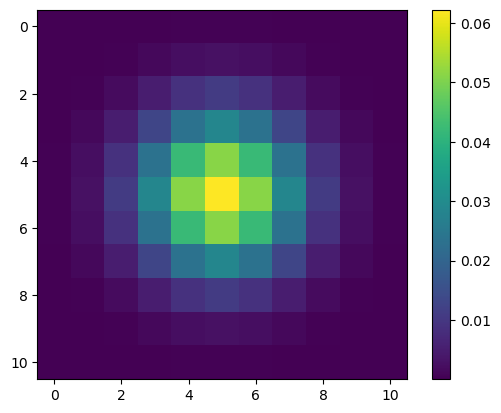

In [2]:


g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()
im = plt.imshow(kernel)
plt.colorbar(im);

In [ ]:

classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

masked_ndvi = ndvi.mask(mask)

With the `DataCube.aggregate_spatial()` method , we can calculate the mean NDVI for each of the fields.

We now use a UDF (user-defined function)
to interpolate the missing values 
and to apply a Savitzky-Golay filter for smoothing of the timeseries, using `scipy.signal.savgol_filter`.

In [6]:
udf = openeo.UDF("""
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
""")

smoothed_ndvi = masked_ndvi.apply_dimension(code=udf, dimension="t")

Now, aggregate this again per field and get the time series.

In [7]:
smoothed_timeseries = smoothed_ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [8]:
smoothed_timeseries.download("output/timeseries-smoothed.json", format="JSON")

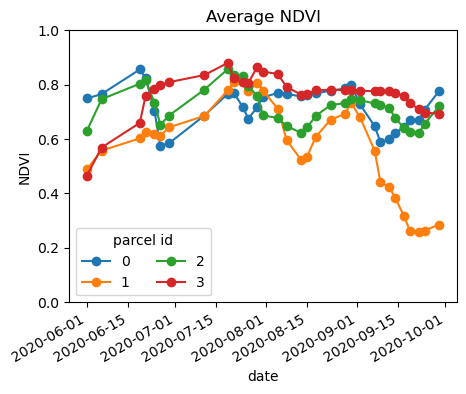

In [5]:
plot_timeseries("output/timeseries-smoothed.json")